<a href="https://colab.research.google.com/github/yilmazgencc/recomender_system/blob/main/recommender_tf_NN_do_0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt

from keras.models import Model

In [2]:
urlretrieve("http://files.grouplens.org/datasets/movielens/ml-1m.zip", "movielens.zip")
ZipFile("movielens.zip", "r").extractall()

ratings_data = pd.read_csv(
    "ml-1m/ratings.dat",
    sep="::",
    names=["user_id", "movie_id", "rating", "unix_timestamp"],
)

ratings_data["movie_id"] = ratings_data["movie_id"].apply(lambda x: f"movie_{x}")
ratings_data["user_id"] = ratings_data["user_id"].apply(lambda x: f"user_{x}")
ratings_data["rating"] = ratings_data["rating"].apply(lambda x: float(x))
del ratings_data["unix_timestamp"]

print(f"Number of users: {len(ratings_data.user_id.unique())}")
print(f"Number of movies: {len(ratings_data.movie_id.unique())}")
print(f"Number of ratings: {len(ratings_data.index)}")


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


Number of users: 6040
Number of movies: 3706
Number of ratings: 1000209


In [3]:
random_selection = np.random.rand(len(ratings_data.index)) <= 0.85
train_data = ratings_data[random_selection]
eval_data = ratings_data[~random_selection]

train_data.to_csv("train_data.csv", index=False, sep="|", header=False)
eval_data.to_csv("eval_data.csv", index=False, sep="|", header=False)
print(f"Train data split: {len(train_data.index)}")
print(f"Eval data split: {len(eval_data.index)}")
print("Train and eval data files are saved.")

Train data split: 850238
Eval data split: 149971
Train and eval data files are saved.


In [4]:
csv_header = list(ratings_data.columns)
user_vocabulary = list(ratings_data.user_id.unique())
movie_vocabulary = list(ratings_data.movie_id.unique())
target_feature_name = "rating"
base_embedding_dim = 64

In [5]:
def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=True):
    return tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=csv_header,
        label_name=target_feature_name,
        num_epochs=1,
        header=False,
        field_delim="|",
        shuffle=shuffle,
    )


def run_experiment(model, learning_rate, batch_size, num_epochs):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        #loss=tf.keras.losses.BinaryCrossentropy(),
        #metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
        metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    # Read the training data.
    train_dataset = get_dataset_from_csv("train_data.csv", batch_size)
    # Read the test data.
    eval_dataset = get_dataset_from_csv("eval_data.csv", batch_size, shuffle=False)
    # Fit the model with the training data.
    history = model.fit(train_dataset, epochs=num_epochs, validation_data=eval_dataset,)
    return history

def embedding_encoder(vocabulary, embedding_dim, num_oov_indices=0, name=None):
    return keras.Sequential(
        [
            StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=num_oov_indices
            ),
            layers.Embedding(
                input_dim=len(vocabulary) + num_oov_indices, output_dim=embedding_dim
            ),
        ],
        name=f"{name}_embedding" if name else None,
    )


In [6]:
def MyModel():
    user_input = layers.Input(name="user_id", shape=(), dtype=tf.string)
    # Get user embedding.
    user_embedding = embedding_encoder(
        vocabulary=user_vocabulary, embedding_dim=base_embedding_dim, name="user"
    )(user_input)

    # Receive the movie as an input.
    movie_input = layers.Input(name="movie_id", shape=(), dtype=tf.string)
    # Get embedding.
    movie_embedding = embedding_encoder(
        vocabulary=movie_vocabulary, embedding_dim=base_embedding_dim, name="movie"
    )(movie_input)

    d=layers.Concatenate(axis=1)([user_embedding, movie_embedding])
    d=layers.Dense(512, activation="relu")(d)
    d=layers.Dropout(0.4)(d)
    d=layers.Dense(256, activation="relu")(d)
    d=layers.Dropout(0.4)(d)
    d=tf.keras.layers.Dense(1, activation="sigmoid")(d)
    output = d * 5

    model = Model(inputs=[user_input, movie_input], outputs=output, name="nn_model")
    #model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    return model
mymodel=MyModel()
mymodel.summary()

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


Model: "nn_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 user_embedding (Sequential)    (None, 64)           386560      ['user_id[0][0]']                
                                                                                                  
 movie_embedding (Sequential)   (None, 64)           237184      ['movie_id[0][0]']               
                                                                                           

Epoch 1/25
831/831 [==============================] - 43s 48ms/step - loss: 1.0283 - accuracy: 0.0560 - rmse: 1.0140 - val_loss: 0.8587 - val_accuracy: 0.0570 - val_rmse: 0.9266
Epoch 2/25
831/831 [==============================] - 37s 44ms/step - loss: 0.8508 - accuracy: 0.0560 - rmse: 0.9224 - val_loss: 0.8247 - val_accuracy: 0.0570 - val_rmse: 0.9081
Epoch 3/25
831/831 [==============================] - 49s 59ms/step - loss: 0.8261 - accuracy: 0.0560 - rmse: 0.9089 - val_loss: 0.8130 - val_accuracy: 0.0570 - val_rmse: 0.9017
Epoch 4/25
831/831 [==============================] - 36s 43ms/step - loss: 0.8108 - accuracy: 0.0560 - rmse: 0.9004 - val_loss: 0.8055 - val_accuracy: 0.0570 - val_rmse: 0.8975
Epoch 5/25
831/831 [==============================] - 35s 42ms/step - loss: 0.7977 - accuracy: 0.0560 - rmse: 0.8932 - val_loss: 0.7988 - val_accuracy: 0.0570 - val_rmse: 0.8938
Epoch 6/25
831/831 [==============================] - 34s 41ms/step - loss: 0.7853 - accuracy: 0.0560 - rmse: 

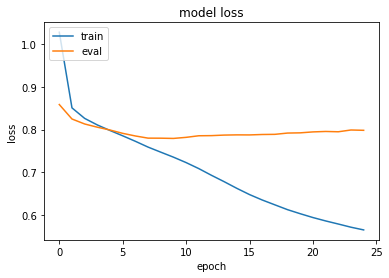

In [7]:
history = run_experiment(mymodel, learning_rate=0.0003, batch_size=1024, num_epochs=25 )
#history = run_experiment(baseline_model, learning_rate=0.0003, batch_size=1024, num_epochs=25)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()

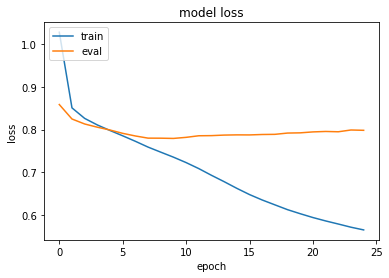

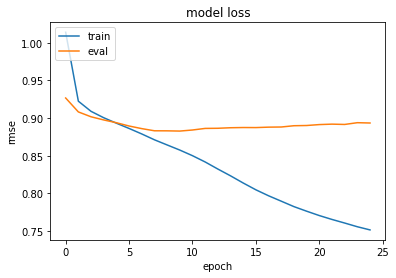

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()
plt.plot(history.history["rmse"])
plt.plot(history.history["val_rmse"])
plt.title("model loss")
plt.ylabel("rmse")
plt.xlabel("epoch")
plt.legend(["train", "eval"], loc="upper left")
plt.show()